In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

import glob
import sys
import os
from collections import OrderedDict

import csv

sys.path.insert(0, "../casa/")
from plot_utils import *
from genome_utils import *

# General Setup
This is a small analysis of _MEF2c_.

Collecting files here.

In [2]:
MFR1_fn = '../data/MEF2C_rep1detailed.txt'
MFR2_fn = '../data/MEF2C_rep2detailed.txt'

fn_list = [MFR1_fn,MFR2_fn]

exp_ids = ['MFR1','MFR2']

fullinfo= [("MEF2C",1), ("MEF2C",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [3]:
# OR type
OR_str = 'lowOR'
# Peak BED files
# MAINTAIN ORDER (see exp_ids variable above)
MFR1_bed= '../data/MEF2C_rep1__{}peaks.bed'.format(OR_str)
MFR2_bed= '../data/MEF2C_rep2__{}peaks.bed'.format(OR_str)

exp_beds= [MFR1_bed, MFR2_bed]

K27_bed = '../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed'
DHS_bed = '../data/DNASE_peaks_replicated.bed'

extra_beds = [ K27_bed, DHS_bed ]
extra_tags = [ 'k27', 'DHS' ]

# Load and preprocess data

In [4]:
gff = pd.read_table('../data/MEF_locus.gff')

/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [5]:
gff

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,proteinID,transcriptID,geneID
0,ENST00000514135.5,chr5,-,88189632,88268830,88190051,88268723,13,"88189632,88196375,88197668,88198975,88202961,8...","88190261,88196488,88197765,88199150,88203075,8...",E9PCX5,uc032vcj.2,TMEM161B
1,ENST00000504921.6,chr5,-,88717116,88883464,88722603,88823788,11,"88717116,88728492,88729217,88730210,88731728,8...","88722925,88728628,88729347,88730234,88731901,8...",Q06413,uc003kjj.4,MEF2C


In [6]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("CTRL")) &\
                           (~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

In [8]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [9]:
# Get experimental peaks
## Read in files
test_peaks = [ pd.read_table(
                 fn,sep='\t',header=None,
                 names=['chr','start','end','hdr','pass','strand']
               ) 
               for fn in exp_beds ]
## Figure out which chromosomes were tested
tested_chr = pd.concat( test_peaks, axis=0 )['chr'].unique()
## Filter out non-significant peaks
test_peaks = [ merge_bed(
                   df.loc[ df['pass'] == True, ('chr','start','end') ].copy()
               )
               for df in test_peaks ]
## Filter out tiny peaks
test_peaks = [ df[ (df['end'] - df['start']) > 100 ]
               for df in test_peaks ]

print("Experimental track count: {}".format(len(test_peaks)))

# Add on extra features from ENCODE
## Read in files
extra_feat = [ pd.read_table(fn,sep='\t',header=None,
                             names=['chr','start','end'],usecols=[0,1,2]) 
               for fn in extra_beds ]
## Filter out un-tested chromosomes for speed
chr_filters = [ np.vstack([feat['chr'] == chrom for chrom in tested_chr ]).any(axis=0) 
                for feat in extra_feat ]

# Combine
[ test_peaks.append( feat.loc[ chr_filter ,:] ) for feat, chr_filter in zip(extra_feat, chr_filters) ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print("Total track count: {}".format(len(test_peaks)))
for exp_id, peaks_idx in zip(exp_ids+extra_tags,range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


Experimental track count: 2
Total track count: 4


/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys
/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: read_table is deprecated, use read_csv instead.


# Plot guide-wise scores with peaks
Lines indicate min-max interval between all replicates.

MEF2C
16


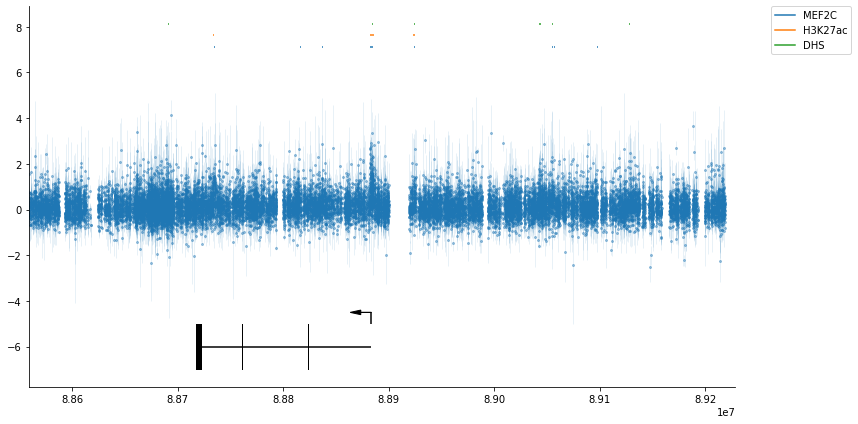

In [10]:
fig_h, ax_h = plot_combined_cutsites(np.array([[88558821,89228820]]), 
          data, test_peaks, plot_ids=['MFR1','MFR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[10000,0.2,10000])
fig_h.savefig('plots/MEF_locus__88558821_89228820.pdf')

MEF2C
0


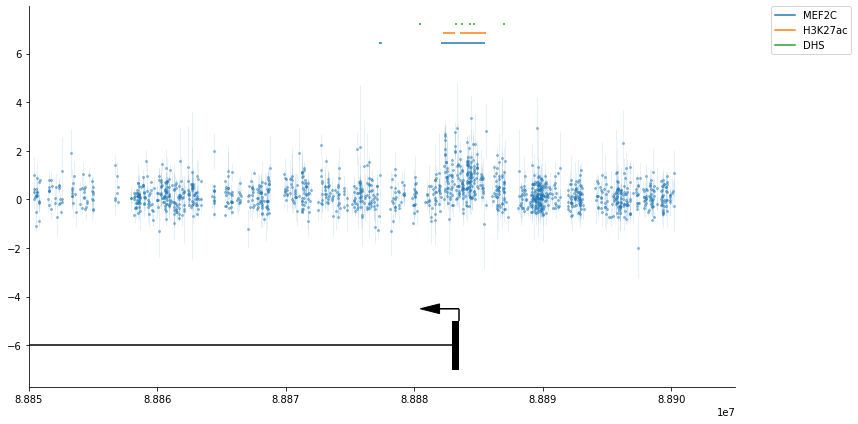

In [11]:
fig_h, ax_h = plot_combined_cutsites(np.array([[88850000,88905000]]), 
          data, test_peaks, plot_ids=['MFR1','MFR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[1500,0.4,1500])
fig_h.savefig('plots/MEF_locus__88850000_88905000.pdf')

MEF2C
2


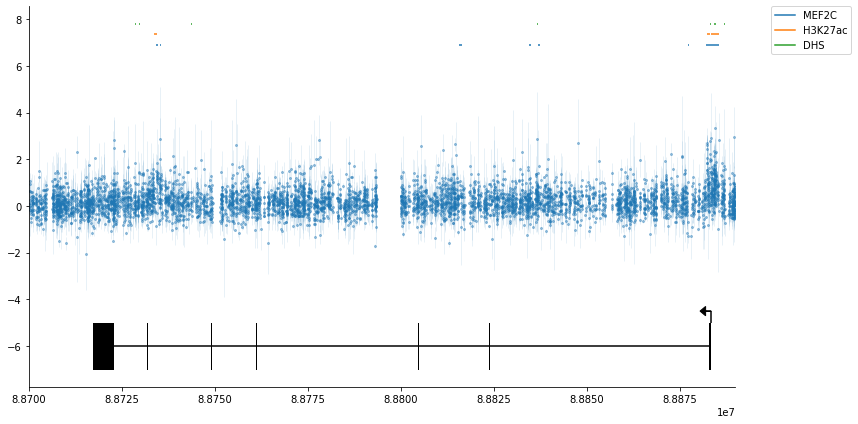

In [12]:
fig_h, ax_h = plot_combined_cutsites(np.array([[88700000,88890000]]), 
          data, test_peaks, plot_ids=['MFR1','MFR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[1500,0.4,1500])
fig_h.savefig('plots/MEF_locus__88700000_88890000.pdf')

# Connection diagram
Summarize CRE promoter interactions

In [13]:
txn_starts = extract_txn_starts(gff)

pack_TSSs   = [('MEF2C',txn_starts['MEF2C'][0],txn_starts['MEF2C'][1])]

In [14]:
txn_starts

{'TMEM161B': ('chr5', 88268830), 'MEF2C': ('chr5', 88883464)}

In [15]:
MEF2C_only_peaks = filter_by_guide_coverage(
    get_replicating_peaks( test_peaks[(test_peaks['assay'] == 'MEF2C')] ), 
    pd.read_table(MFR1_fn,sep='\t',header=0)['Coordinates'], min_coverage=29
)

pack_peaks       = [MEF2C_only_peaks]

all_locus_peaks = pd.concat(pack_peaks).reset_index(drop=True)

/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
all_locus_peaks

,chr,start,end,guide_coverage
0,chr5,88836814,88837414,30
1,chr5,88882114,88885514,189
2,chr5,89054814,89055614,31


In [17]:
MEF2C_total_scores = get_peak_strengths(MFR1_bed, MFR2_bed)

pack_scores = [MEF2C_total_scores]


../casa/plot_utils.py:312: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  for fn in argv ]


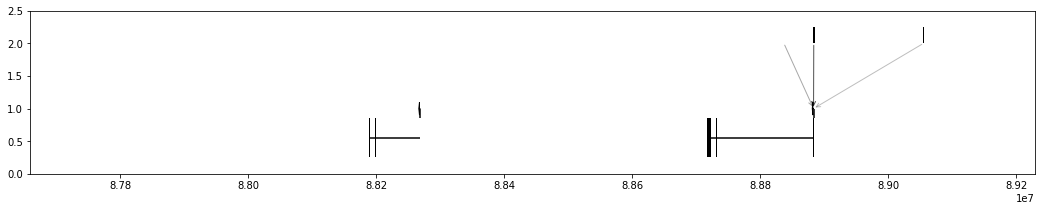

In [18]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [87659632,89228820]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['MEF2C'], y_anchor=2.0, y_target=1.0, score_bed=MEF2C_total_scores, xlims=glims)

plt.savefig('plots/MEF_locus__full_locus__connectogram__{}.pdf'.format(OR_str))

plt.show()

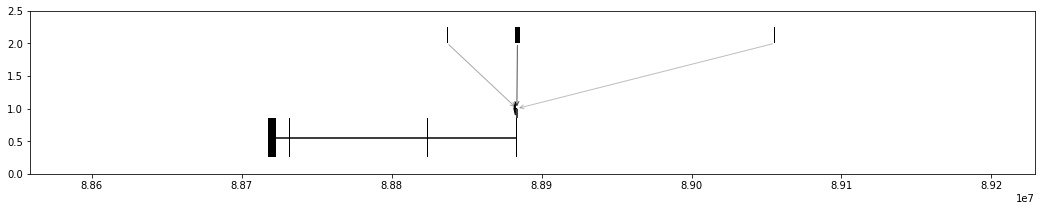

In [19]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [88558821,89228820]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['MEF2C'], y_anchor=2.0, y_target=1.0, score_bed=MEF2C_total_scores, xlims=glims)

plt.savefig('plots/MEF_locus__88558821_89228820__connectogram__{}.pdf'.format(OR_str))

plt.show()

In [20]:
write_bed_format([ x.iloc[:,0:3] for x in pack_peaks ], pack_scores, pack_TSSs, 
                 '../data/MEF2C__replicating_peaks__{}.bed'.format(OR_str))